# DS Salary Prediction
- Predict salary of data scientist related role


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# to get data
import os
import kagglehub
import shutil

In [2]:
import sys
print(sys.executable)

D:\anaconda3\python.exe


In [3]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.6.1.


## 1. Get Data

In [4]:
DATA_LOCAL_PATH = os.path.join("datasets", "salaries")
DATA_URL = "saurabhbadole/latest-data-science-job-salaries-2024"

In [5]:
def download_kaggle_dataset(dataset_name=DATA_URL, local_path=DATA_LOCAL_PATH, force=False):
    """
    Downloads a Kaggle dataset to a specified local path.

    Parameters:
    - dataset_name (str): The Kaggle dataset identifier (e.g., "saurabhbadole/latest-data-science-job-salaries-2024").
    - local_path (str): The local directory to save the dataset.
    - fprce (boolean): if True, it will overwrite existing datasets
    """
    if not os.path.exists(local_path):
        os.makedirs(local_path) 
    else:
        print('Datasets already exists')
        return
    
    if force == True:
        shutil.rmtree(local_path) 
    
    cache_path = kagglehub.dataset_download(dataset_name)
    shutil.move(cache_path, local_path)
    
    
download_kaggle_dataset()

Datasets already exists


In [6]:
def load_salaries_data(salaries_path=DATA_LOCAL_PATH):
    csv_path = os.path.join(salaries_path, "3", "DataScience_salaries_2025.csv")
    
    return pd.read_csv(csv_path)

In [7]:
ds_jobs = load_salaries_data()
ds_jobs.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Research Scientist,208000,USD,208000,US,0,US,M
1,2025,MI,FT,Research Scientist,147000,USD,147000,US,0,US,M
2,2025,SE,FT,Research Scientist,173000,USD,173000,US,0,US,M
3,2025,SE,FT,Research Scientist,117000,USD,117000,US,0,US,M
4,2025,MI,FT,AI Engineer,100000,USD,100000,US,100,US,M


In [8]:
ds_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93597 entries, 0 to 93596
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           93597 non-null  int64 
 1   experience_level    93597 non-null  object
 2   employment_type     93597 non-null  object
 3   job_title           93597 non-null  object
 4   salary              93597 non-null  int64 
 5   salary_currency     93597 non-null  object
 6   salary_in_usd       93597 non-null  int64 
 7   employee_residence  93597 non-null  object
 8   remote_ratio        93597 non-null  int64 
 9   company_location    93597 non-null  object
 10  company_size        93597 non-null  object
dtypes: int64(4), object(7)
memory usage: 7.9+ MB


This data science salaries dataset by 2025 have 93597 rows, relatively large for a dataset. We will figure out how to handle this.

The data has no missing values, 4 int attributes, and the rest is object.

In [9]:
# look at object values
obj_cols = ds_jobs.select_dtypes(include='O').columns

for col in obj_cols:
    print(ds_jobs[col].value_counts(), '\n')

SE    54645
MI    28140
EN     8849
EX     1963
Name: experience_level, dtype: int64 

FT    93090
PT      247
CT      244
FL       16
Name: employment_type, dtype: int64 

Data Scientist                  13848
Data Engineer                   11323
Software Engineer               10133
Data Analyst                     9081
Machine Learning Engineer        6643
                                ...  
Controls Engineer                   1
Marketing Data Scientist            1
Business Development Manager        1
Business Insights Manager           1
Platform Data Engineer              1
Name: job_title, Length: 317, dtype: int64 

USD    88796
GBP     2563
EUR     1643
CAD      307
INR       80
PLN       49
CHF       36
BRL       20
AUD       18
SGD       15
PHP       14
JPY       10
TWD        9
HUF        7
DKK        5
TRY        4
NOK        3
CZK        3
MXN        3
ILS        3
ZAR        3
THB        2
SEK        1
NZD        1
HKD        1
CLP        1
Name: salary_currency, dty

In [10]:
ds_jobs.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,93597.000000,9.359700e+04,93597.000000,93597.000000
mean,2024.086434,1.623541e+05,157547.696774,21.455816
std,0.641449,2.221425e+05,73649.113729,40.954704
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,1.062600e+05,106250.000000,0.000000
50%,2024.000000,1.470000e+05,146232.000000,0.000000
75%,2024.000000,1.990000e+05,198000.000000,0.000000
max,2025.000000,3.040000e+07,800000.000000,100.000000


In [11]:
ds_jobs.remote_ratio.value_counts()

0      73366
100    19933
50       298
Name: remote_ratio, dtype: int64

remote_ratio looks more like object attribute rather than numerical. So we will convert that to object types.

array([[<Axes: title={'center': 'work_year'}>,
        <Axes: title={'center': 'salary'}>],
       [<Axes: title={'center': 'salary_in_usd'}>,
        <Axes: title={'center': 'remote_ratio'}>]], dtype=object)

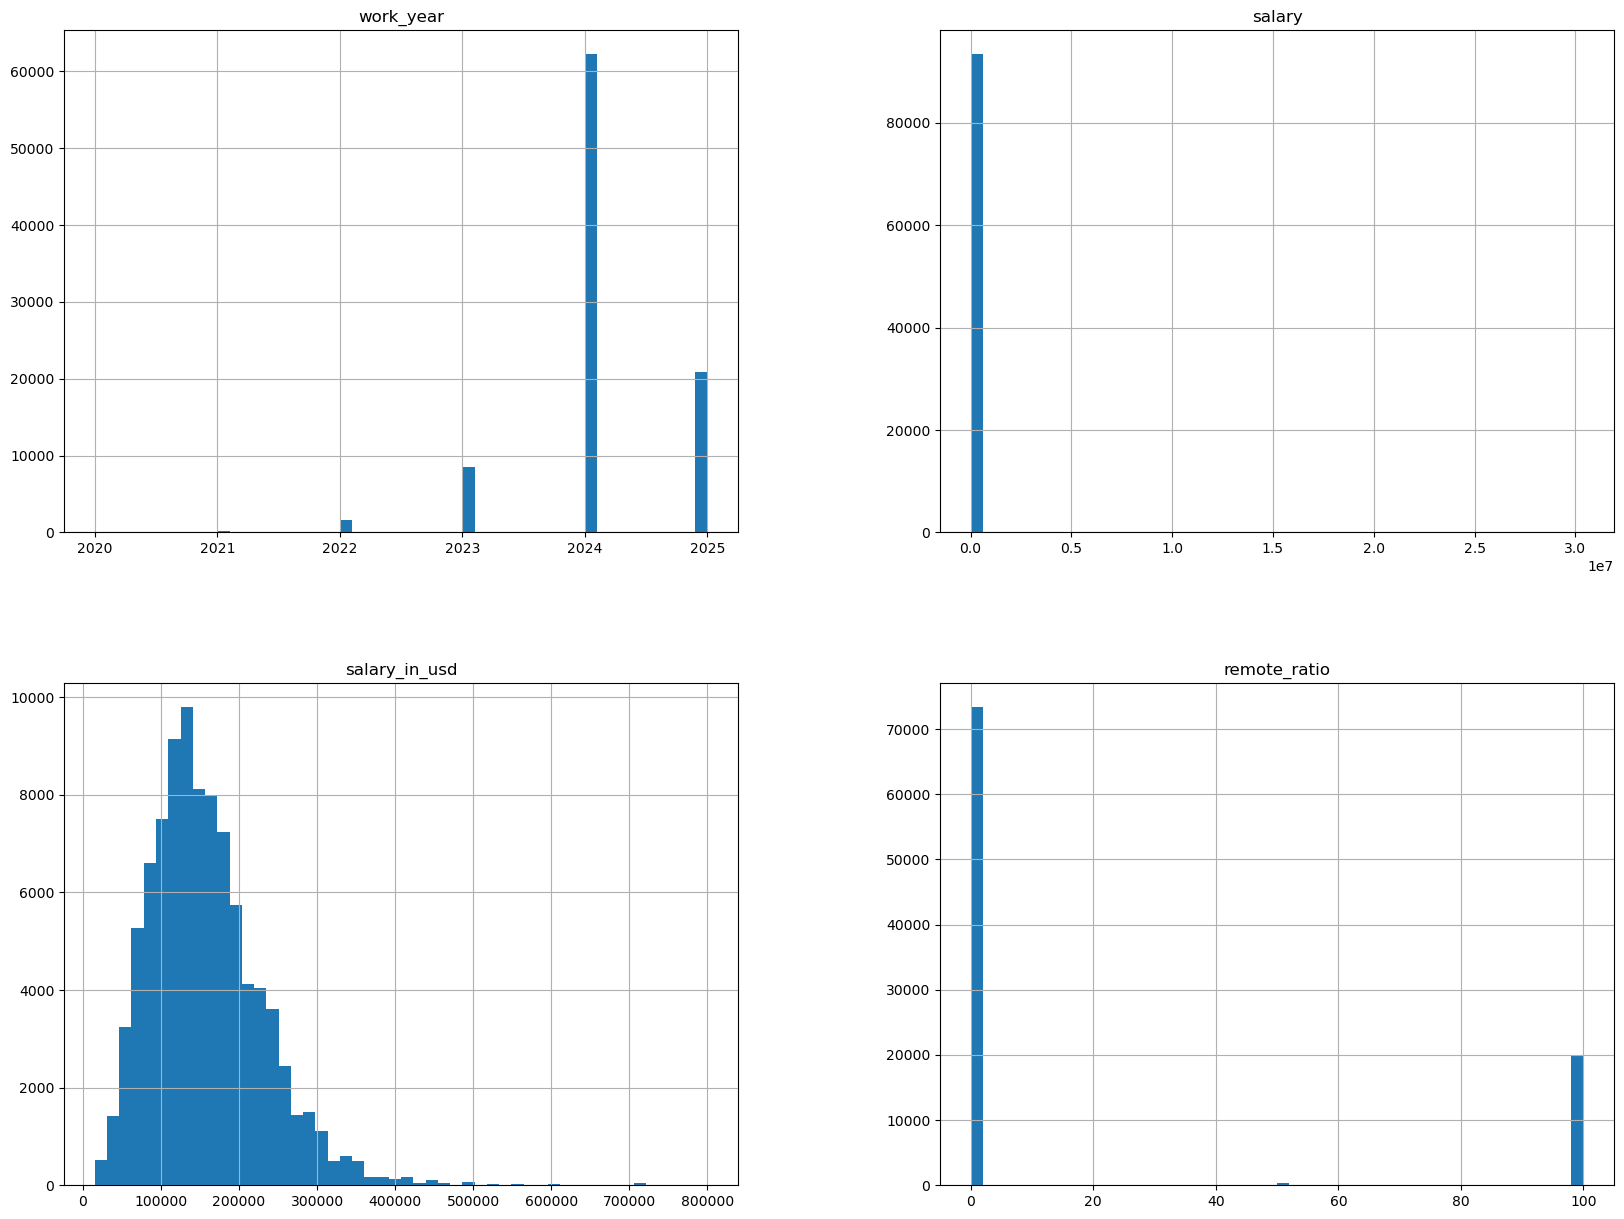

In [12]:
ds_jobs.hist(bins=50, figsize=(20,15))

`From the histogram, we can see that:
- all attributes are highly skewed, we may will transform it to have more gaussian bell curve shaped later.
- These attributes have very different scale, we will scale the values.
- Salary attribute seems have very wide range of values, maybe because it represents values in many different counrty cucrency. So we wil ignore this value and use only salary_in_usd. 

## 2. Create a Test Set
As experience_level has high contribution on target, we want to separate y with same proportion sampling based on experience_level.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(ds_jobs, ds_jobs['experience_level']):
    strat_train_set = ds_jobs.iloc[train_index]
    strat_test_set = ds_jobs.iloc[test_index]

## Discover and Visualize the Data to Gain Insights

In [14]:
ds_jobs = strat_train_set.copy()

In [15]:
ds_jobs.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
68508,2024,SE,FT,Data Scientist,286000,USD,286000,US,0,US,M
90807,2023,MI,FT,Data Analyst,36050,GBP,44356,GB,100,GB,M
21196,2024,SE,FT,AI Engineer,185000,USD,185000,US,0,US,M
44547,2024,MI,FT,Data Engineer,51360,EUR,57066,NL,0,NL,M
15939,2025,SE,FT,Data Analyst,172000,USD,172000,US,0,US,M


### Visualize Attributes

In [16]:
work_year_count = ds_jobs.work_year.value_counts().sort_index()
work_year_count

2020       49
2021      147
2022     1139
2023     5994
2024    43553
2025    14635
Name: work_year, dtype: int64

Text(0.5, 1.0, 'Num of Salary Records per Year')

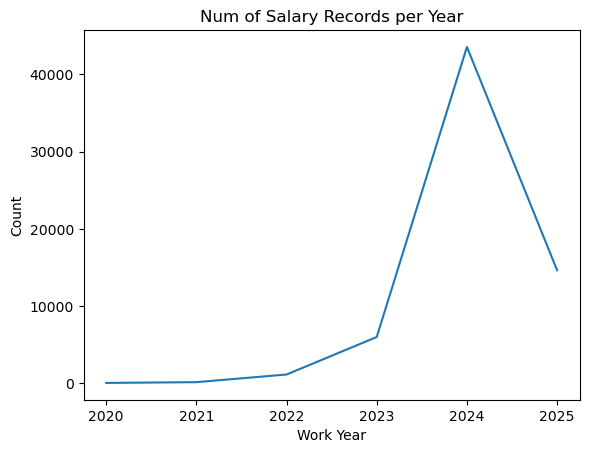

In [17]:
plt.plot(work_year_count.index, work_year_count)
plt.xlabel('Work Year')
plt.ylabel('Count')
plt.xticks(work_year_count.index)
plt.title('Num of Salary Records per Year')

We can see that data science jobs started booming in recent years.

Text(0.5, 1.0, 'Work Year Salary Distribution')

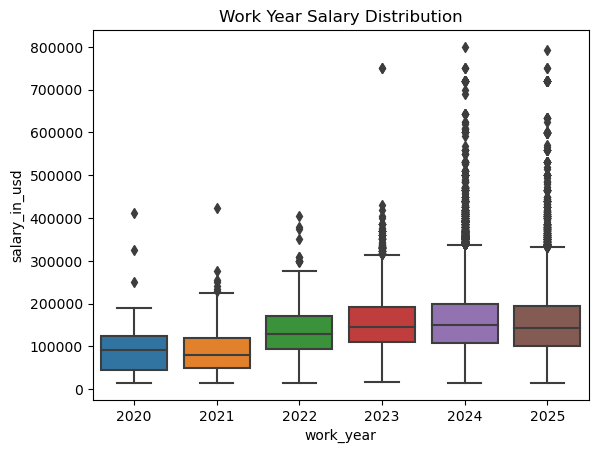

In [18]:
sns.boxplot(x='work_year', y='salary_in_usd', data=ds_jobs)
plt.title('Work Year Salary Distribution')

Text(0.5, 1.0, 'Work Year Salary Distribution')

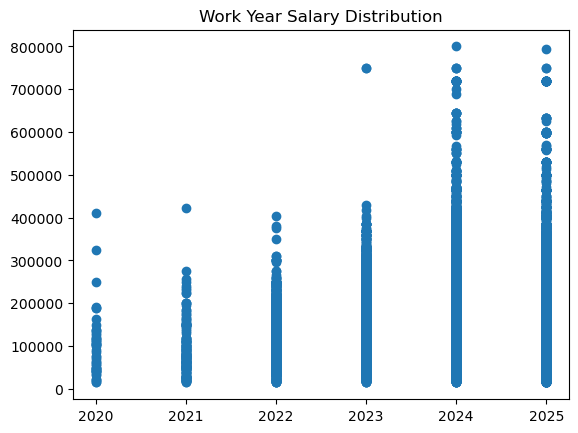

In [19]:
plt.scatter(x='work_year', y='salary_in_usd', data=ds_jobs)
plt.title('Work Year Salary Distribution')

Salary is increasing as year increases.

Text(0.5, 1.0, 'Experience Level Salary Distribution')

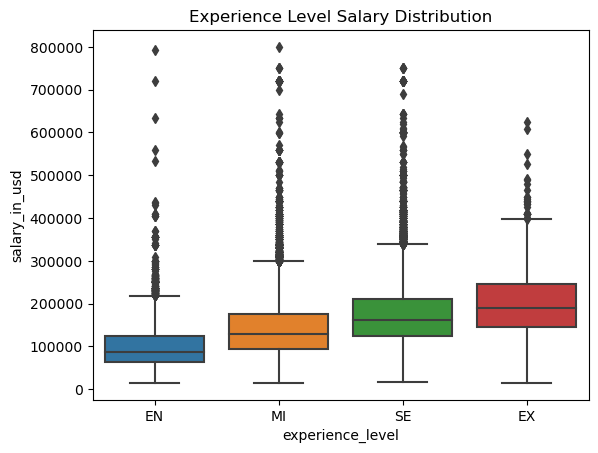

In [20]:
sns.boxplot(x='experience_level', y='salary_in_usd', data=ds_jobs, order=['EN', 'MI', 'SE', 'EX'])
plt.title('Experience Level Salary Distribution')

The plot shows increasing order of salary as the experince level gets higher.

In [21]:
ds_jobs.employment_type.value_counts()

FT    65143
PT      189
CT      176
FL        9
Name: employment_type, dtype: int64

In [22]:
fulltime_salary = ds_jobs[ds_jobs.employment_type=='FT']['salary_in_usd'].mean()
non_fulltime_salary = ds_jobs[ds_jobs.employment_type!='FT']['salary_in_usd'].mean()

print(f'Fulltime salary: {fulltime_salary}')
print(f'Non Fulltime salary: {non_fulltime_salary}')

Fulltime salary: 158069.51856684525
Non Fulltime salary: 84549.4679144385


Most employees have fulltime job and other types have small presence. Fulltime job also have higher paying than not. 

So later we want to preprocess employment_type into just two values: fulltime or not.

In [23]:
ds_jobs.job_title.unique()

array(['Data Scientist', 'Data Analyst', 'AI Engineer', 'Data Engineer',
       'Analytics Engineer', 'Engineer', 'Data Quality Lead', 'Analyst',
       'Data Architect', 'Product Manager', 'Software Engineer',
       'Machine Learning Engineer', 'Manager', 'Head of Data',
       'Research Scientist', 'Site Reliability Engineer',
       'Data Visualization Engineer', 'Applied Scientist', 'Associate',
       'Software Developer', 'Developer', 'Business Intelligence Analyst',
       'Software Development Engineer', 'Machine Learning Researcher',
       'Prompt Engineer', 'Data Analytics Manager', 'Consultant',
       'Data Team Lead', 'Business Intelligence',
       'Principal Data Scientist', 'Data Quality Specialist',
       'Solutions Architect', 'Data Lead', 'Data Governance Analyst',
       'Data Management Specialist', 'Data Developer',
       'Engineering Manager', 'Data Manager', 'AI Developer',
       'Data Governance', 'Research Analyst',
       'Artificial Intelligence Enginee

There are many different values in job_title that actually share similar meaning. So later, I want to combine job_title with similar meaning into one like : Data Analyst, Data scientist, Data engineer, Machine learning engineer, AI engineer

In [24]:
ds_jobs.salary_currency.value_counts()

USD    62170
GBP     1798
EUR     1141
CAD      213
INR       52
PLN       38
CHF       24
AUD       13
PHP       12
BRL       12
SGD        8
HUF        6
JPY        6
DKK        4
TWD        4
MXN        3
ZAR        3
TRY        2
CZK        2
THB        2
ILS        2
HKD        1
NOK        1
Name: salary_currency, dtype: int64

In [25]:
usd_currency = ds_jobs[ds_jobs.salary_currency=='USD']['salary_in_usd'].mean()
non_usd_currency = ds_jobs[ds_jobs.salary_currency!='USD']['salary_in_usd'].mean()

print(f'usd_currency: {usd_currency}')
print(f'Non usd_currency: {non_usd_currency}')

usd_currency: 161892.10437510052
Non usd_currency: 78850.31968927398


Most of currency is in USD, while some currency have very small occurrence. USD currency also have higher paying than not. 

So later we want to preprocess salary_currency into just two values: usd or not.

Text(0.5, 1.0, 'Salary Distributions')

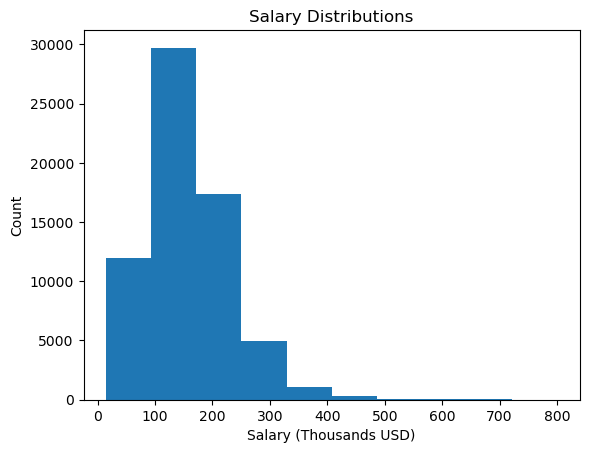

In [26]:
salary_usd_in_k = ds_jobs.salary_in_usd /1000

plt.hist(salary_usd_in_k)
plt.xlabel('Salary (Thousands USD)')
plt.ylabel('Count')
plt.title('Salary Distributions')

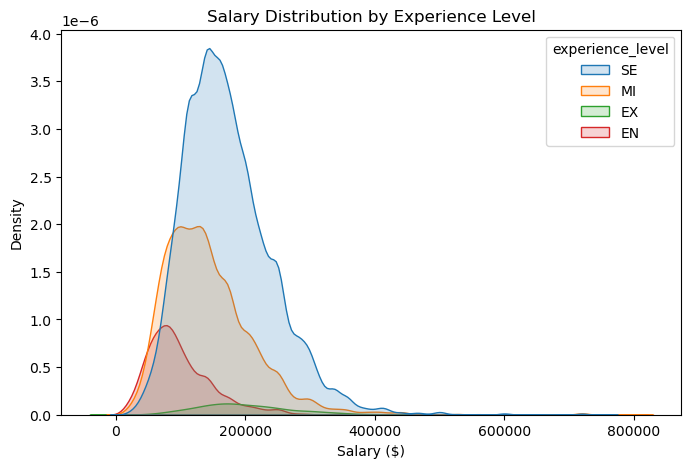

In [27]:
# Plot density
plt.figure(figsize=(8, 5))
sns.kdeplot(data=ds_jobs, x="salary_in_usd", hue="experience_level", fill=True, alpha=0.2)

# Labels
plt.xlabel("Salary ($)")
plt.ylabel("Density")
plt.title("Salary Distribution by Experience Level")
plt.show()

Salary is highly correlated with experience level of employee.

In [28]:
ds_jobs.employee_residence.value_counts()

US    59009
CA     2412
GB     1874
AU      216
DE      189
      ...  
UG        1
SA        1
KW        1
DZ        1
VE        1
Name: employee_residence, Length: 94, dtype: int64

In [29]:
us_employee_residence = ds_jobs[ds_jobs.employee_residence=='US']['salary_in_usd'].mean()
non_us_employee_residence = ds_jobs[ds_jobs.employee_residence!='US']['salary_in_usd'].mean()

print(f'us_employee_residence: {us_employee_residence}')
print(f'Non us_employee_residence: {non_us_employee_residence}')

us_employee_residence: 163551.61465200223
Non us_employee_residence: 104137.51075599263


Mpst of employess live in US, mostly employees are in Europe like UK, Spanyol, German. Outside that have small counts.

US employee residence also have higher paying than not. 

So later we want to preprocess employee_residence into just two values: us or not.

In [30]:
ds_jobs.groupby('remote_ratio').agg(
    count_remote_type= ('salary_in_usd', 'count'),
    avg_remote_type = ('salary_in_usd', 'mean')
)

,count_remote_type,avg_remote_type
remote_ratio,,
0,51330,160341.948139
50,205,82039.321951
100,13982,148875.260335


The salary relatively same for either fulltime or remote.

In [31]:
ds_jobs.company_location.value_counts()

US    59048
CA     2411
GB     1883
AU      222
DE      196
      ...  
QA        1
MD        1
CD        1
SA        1
GI        1
Name: company_location, Length: 88, dtype: int64

In [32]:
us_company_location = ds_jobs[ds_jobs.company_location=='US']['salary_in_usd'].mean()
non_us_company_location = ds_jobs[ds_jobs.company_location!='US']['salary_in_usd'].mean()

print(f'us_company_location: {us_company_location}')
print(f'Non us_company_location: {non_us_company_location}')

us_company_location: 163501.73289527165
Non us_company_location: 104234.63054567939


Most companies are also based in US. US company also give higher salary than not.

So later we want to preprocess company_location into just two values: us or not.

<Axes: xlabel='company_size', ylabel='salary_in_usd'>

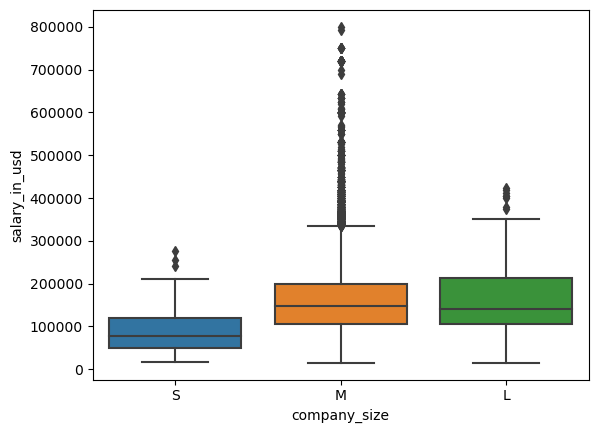

In [33]:
sns.boxplot(x='company_size', y='salary_in_usd', data=ds_jobs, order=['S', 'M', 'L'])

The size of company contirbutes to the salary ranges. Large companies tend to give higher salary

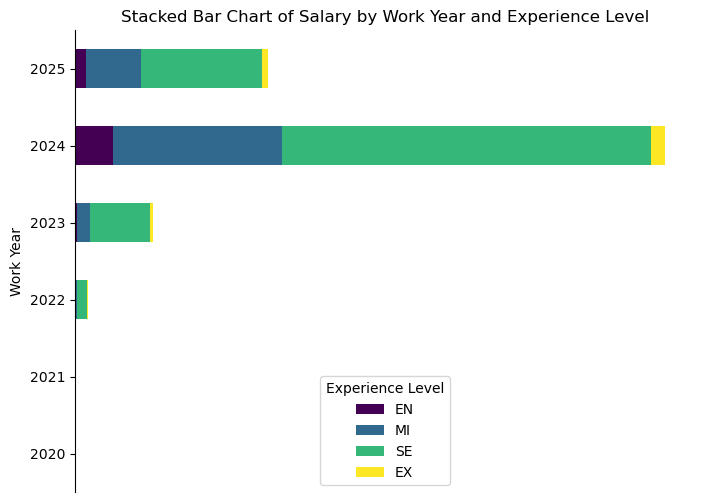

In [34]:
pivot_df = ds_jobs.pivot_table(values='salary_in_usd', index='work_year', columns='experience_level', aggfunc='sum', fill_value=0)

experience_order = ['EN', 'MI', 'SE', 'EX']
pivot_df = pivot_df[experience_order]

ax = pivot_df.plot(kind='barh', stacked=True, colormap="viridis", figsize=(8, 6))

plt.ylabel("Work Year")
plt.xlabel("Salary in USD")
plt.title("Stacked Bar Chart of Salary by Work Year and Experience Level")
plt.legend(title="Experience Level", loc='lower center')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)  
ax.xaxis.set_visible(False)  

plt.show()



Data Science and AI jobs mostly dominated by senior level experience.

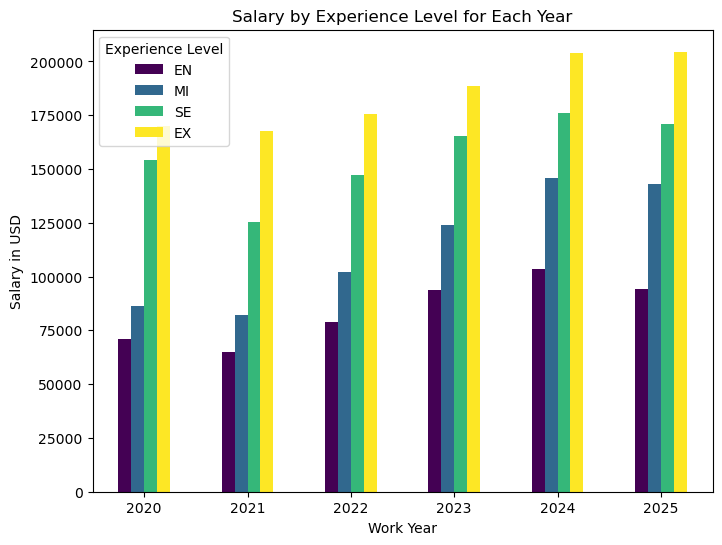

In [35]:
pivot_df = ds_jobs.pivot_table(values='salary_in_usd', index='work_year', columns='experience_level', aggfunc='mean', fill_value=0)

experience_order = ['EN', 'MI', 'SE', 'EX']
pivot_df = pivot_df[experience_order]

ax = pivot_df.plot(kind='bar', colormap="viridis", figsize=(8, 6))

plt.xlabel("Work Year")
plt.ylabel("Salary in USD")
plt.title("Salary by Experience Level for Each Year")
plt.legend(title="Experience Level")
plt.xticks(rotation=0)

plt.show()



Salary relatively increasing by year, but the salary for each level experience have similar range.

## 3. Check Outliers

Check outliers in salary by Experience_Level

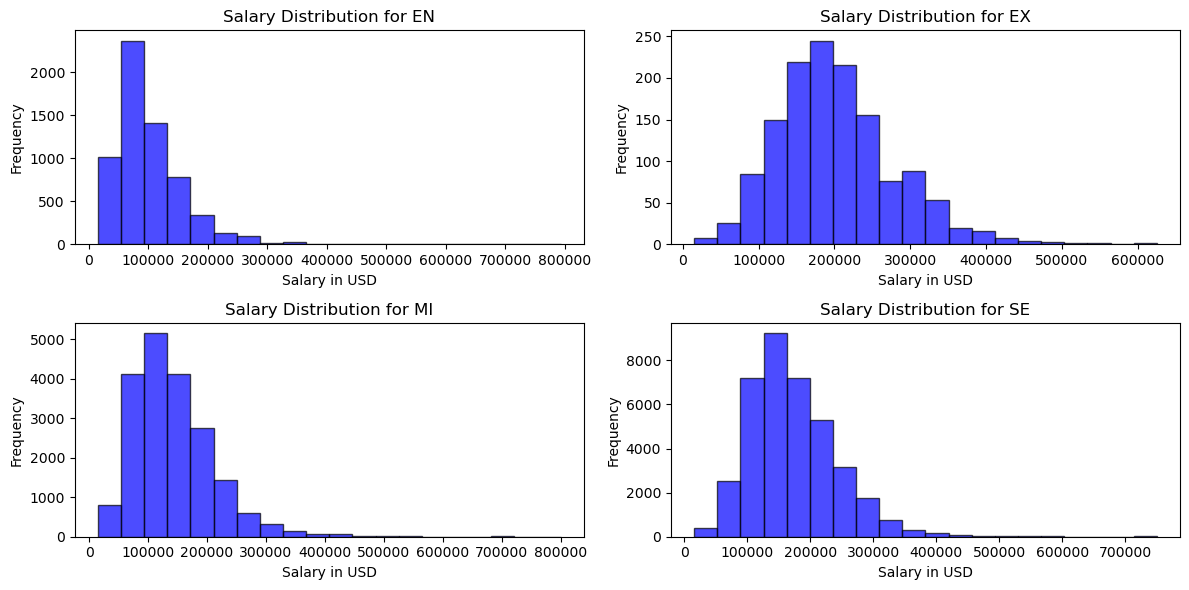

In [36]:
def plot_histogram_salary_of_experience(df):
    experience_levels = df['experience_level'].unique()
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # Create a 2x2 grid

    axes = axes.flatten()  

    for i, (exp, exp_salary_df) in enumerate(df.groupby('experience_level')):
        axes[i].hist(exp_salary_df.salary_in_usd, bins=20, alpha=0.7, color='blue', edgecolor='black')
        axes[i].set_title(f'Salary Distribution for {exp}')
        axes[i].set_xlabel('Salary in USD')
        axes[i].set_ylabel('Frequency')

    # Hide any unused subplots if less than 4 experience levels exist
    for j in range(i + 1, 4):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

plot_histogram_salary_of_experience(ds_jobs)

In [37]:
def remove_outlier_salary(df):
    df_out = pd.DataFrame()
    for exp, exp_df in df.groupby('experience_level'):
        mean = np.mean(exp_df['salary_in_usd'])
        std = np.std(exp_df['salary_in_usd'])
        exp_df = exp_df[(exp_df['salary_in_usd'] >= (mean-2*std)) & (exp_df['salary_in_usd'] <= (mean+2*std))]
        df_out = pd.concat([df_out, exp_df])
    return df_out


In [38]:
cleaned_dsjobs = remove_outlier_salary(ds_jobs)
cleaned_dsjobs.shape

(63130, 11)

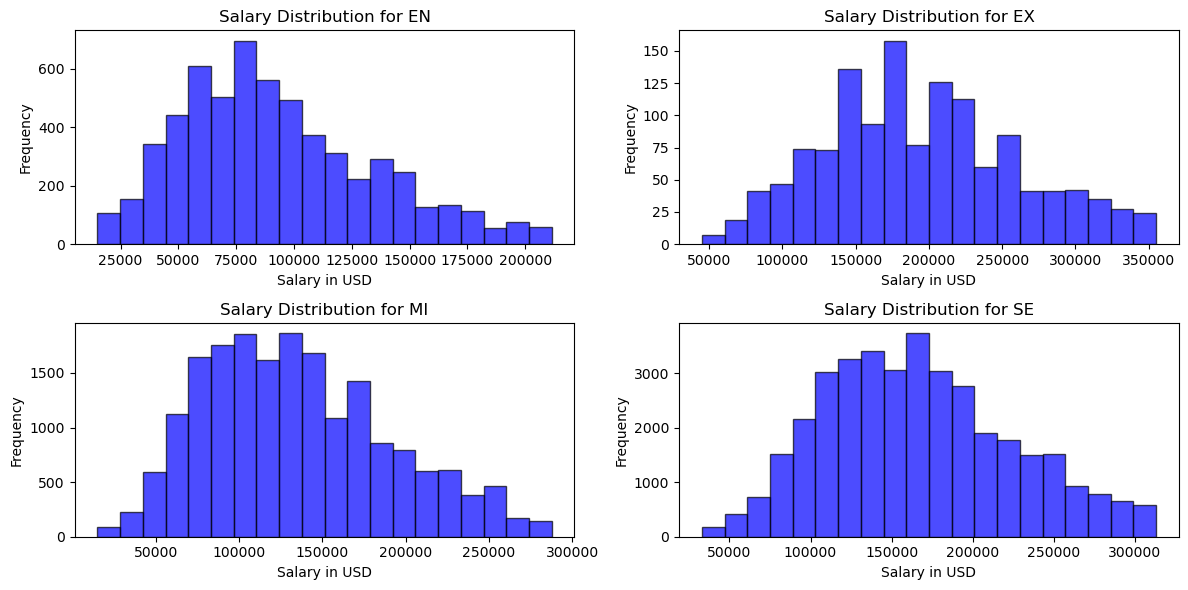

In [39]:
plot_histogram_salary_of_experience(cleaned_dsjobs)

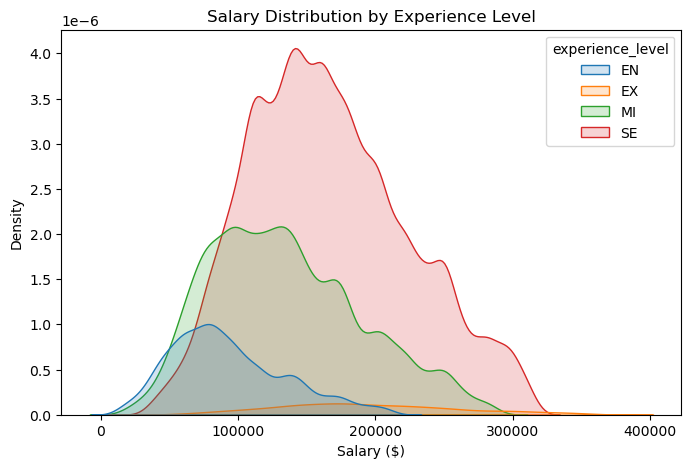

In [40]:
# Plot density
plt.figure(figsize=(8, 5))
sns.kdeplot(data=cleaned_dsjobs, x="salary_in_usd", hue="experience_level", fill=True, alpha=0.2)

# Labels
plt.xlabel("Salary ($)")
plt.ylabel("Density")
plt.title("Salary Distribution by Experience Level")
plt.show()

## 3. Data Wrangling

In [41]:
cleaned_dsjobs.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [42]:
# from sklearn.preprocessing import OrdinalEncoder

# year_encoder = OrdinalEncoder()

# year_encoder.fit_transform(cleaned_dsjobs[['work_year']])

In [43]:
# encode categorical values into number

def encode_categorical_values(df):
    df = df.copy()
    
    # Encode ordinal categorical features
    df['experience_level'] = df['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
    df['company_size'] = df['company_size'].replace({'S': 1, 'M': 2, 'L': 3})

    # Trim spaces from employment type
    df['employment_type'] = df['employment_type'].str.strip()
    
    # Convert binary categorical features
    df['fulltime_emp'] = (df['employment_type'] == 'FT').astype(int)
    df['us_currency'] = (df['salary_currency'] == 'USD').astype(int)
    df['us_emp_residence'] = (df['employee_residence'] == 'US').astype(int)
    df['us_company_loc'] = (df['company_location'] == 'US').astype(int)

    return df


df2 = encode_categorical_values(cleaned_dsjobs)
df2.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,fulltime_emp,us_currency,us_emp_residence,us_company_loc
22558,2024,1,FT,Analyst,75000,USD,75000,US,100,US,2,1,1,1,1
30004,2024,1,FT,Data Analyst,90400,USD,90400,US,0,US,2,1,1,1,1
81932,2024,1,FT,Data Analyst,55000,GBP,68750,GB,0,GB,2,1,0,0,0
52858,2024,1,FT,Data Analyst,90000,USD,90000,US,100,US,2,1,1,1,1
75991,2024,1,FT,Data Analyst,100000,USD,100000,US,0,US,2,1,1,1,1


In [44]:
# check job title values

job_title = df2.job_title.unique()
job_title

array(['Analyst', 'Data Analyst', 'Developer',
       'Machine Learning Engineer', 'Prompt Engineer',
       'Data Governance Analyst', 'Software Engineer', 'Data Engineer',
       'Engineer', 'Data Scientist', 'Software Development Engineer',
       'Research Analyst', 'Business Intelligence',
       'Quantitative Research Analyst', 'Machine Learning Developer',
       'Sales Development Representative', 'AI Engineer', 'Power BI',
       'Data Operations Analyst', 'Research Scientist',
       'Business Analyst', 'Data Specialist', 'AI Developer',
       'Business Intelligence Analyst', 'Research Assistant',
       'Data Quality Analyst', 'Associate', 'Data Management Analyst',
       'Applied Scientist', 'Actuarial Analyst', 'Big Data Engineer',
       'Data Platform Engineer', 'Data Reporting Analyst',
       'AI Programmer', 'Power BI Developer', 'Quantitative Analyst',
       'Consultant', 'Manager', 'Insight Analyst', 'Architect',
       'Product Analyst', 'Research Associate',
  

In [45]:
len(job_title)

299

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

job_titles = df2["job_title"].tolist()
categories = ['AI Engineer', 'Data Architect/ Data ETL Cloud Engineer/ Data Engineer',
       'Data Scientist', 'Data Analyst/Data Specialist', 'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer',
       'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect', 'Tableau/BI Analyst/ Business Intelligence Specialist', 'Software Engineer']

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(job_titles + categories)

job_vectors = vectors[: len(job_titles)]
category_vectors = vectors[len(job_titles) :]

similarities = cosine_similarity(job_vectors, category_vectors)
df3 = df2.copy()
df3["category"] = [categories[i] for i in similarities.argmax(axis=1)]
df3["similarities"] = similarities.max(axis=1) 

df3.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,fulltime_emp,us_currency,us_emp_residence,us_company_loc,category,similarities
22558,2024,1,FT,Analyst,75000,USD,75000,US,100,US,2,1,1,1,1,Data Analyst/Data Specialist,0.406473
30004,2024,1,FT,Data Analyst,90400,USD,90400,US,0,US,2,1,1,1,1,Data Analyst/Data Specialist,0.614915
81932,2024,1,FT,Data Analyst,55000,GBP,68750,GB,0,GB,2,1,0,0,0,Data Analyst/Data Specialist,0.614915
52858,2024,1,FT,Data Analyst,90000,USD,90000,US,100,US,2,1,1,1,1,Data Analyst/Data Specialist,0.614915
75991,2024,1,FT,Data Analyst,100000,USD,100000,US,0,US,2,1,1,1,1,Data Analyst/Data Specialist,0.614915


In [47]:
df3[['job_title', 'category', 'similarities']].drop_duplicates()

,job_title,category,similarities
22558,Analyst,Data Analyst/Data Specialist,0.406473
30004,Data Analyst,Data Analyst/Data Specialist,0.614915
25263,Developer,AI Engineer,0.000000
64338,Machine Learning Engineer,Computer Vision/NLP/Deep Learning/Machine Lear...,0.397310
13242,Prompt Engineer,Software Engineer,0.103557
...,...,...,...
91227,Azure Data Engineer,Data Architect/ Data ETL Cloud Engineer/ Data ...,0.102286
88831,Software Data Engineer,Software Engineer,0.895162
92443,Marketing Data Analyst,Data Analyst/Data Specialist,0.206274
90695,Deep Learning Researcher,Computer Vision/NLP/Deep Learning/Machine Lear...,0.484663


In [48]:
df3.loc[df3.similarities <0.2][['job_title', 'category', 'similarities']].drop_duplicates().sample(5)

,job_title,category,similarities
93559,Finance Data Analyst,Data Analyst/Data Specialist,0.176652
9132,Developer Advocate,AI Engineer,0.000000
61932,Research Associate,AI Engineer,0.000000
33344,Quantitative Analyst,Data Analyst/Data Specialist,0.150251
13972,Python Developer,AI Engineer,0.000000


In [49]:
df3.loc[(df3.similarities >0.2) & (df3.similarities <0.5)][['job_title', 'category', 'similarities']].drop_duplicates().sort_values(by='similarities')

,job_title,category,similarities
39465,Research Engineer,Software Engineer,0.201075
24490,Data Developer,Data Scientist,0.202015
61845,Data Integrity Analyst,Data Analyst/Data Specialist,0.204622
40936,Power BI Consultant,Tableau/BI Analyst/ Business Intelligence Spec...,0.204773
92443,Marketing Data Analyst,Data Analyst/Data Specialist,0.206274
...,...,...,...
92290,Data Scientist Lead,Data Scientist,0.486836
92898,Lead Data Scientist,Data Scientist,0.486836
9249,Tech Lead,Tech/Technical/IT Lead/Head/Director/Manager/S...,0.489447
2836,Software Architect,Software Engineer,0.494186


In [50]:
df4 = df3[df3.similarities > 0.2]

In [51]:
for category in categories:
    print(category)
    print(df4.loc[df4.category == category]['job_title'].unique())
    print()

AI Engineer
['AI Engineer' 'AI Developer' 'AI Programmer' 'AI Scientist'
 'AI Data Engineer' 'AI Research Engineer' 'AI Research Scientist'
 'AI Data Scientist' 'AI Specialist' 'AI Researcher'
 'AI Software Engineer' 'Head of AI' 'AI Architect' 'AI Product Manager'
 'AI Product Owner' 'AI Lead' 'AI Solution Architect' 'AI Governance Lead'
 'AI Machine Learning Engineer' 'AI Engineering Manager'
 'Applied AI ML Lead']

Data Architect/ Data ETL Cloud Engineer/ Data Engineer
['Data Engineer' 'Architect' 'Data Architect' 'Cloud Engineer'
 'Cloud Data Engineer' 'ETL Developer' 'ETL Engineer'
 'Cloud Database Administrator' 'Cloud Database Engineer'
 'Data Analytics Engineer' 'Cloud Developer' 'Principal Data Architect'
 'Data Governance Architect' 'Big Data Architect']

Data Scientist
['Data Scientist' 'Research Scientist' 'Applied Scientist' 'Data Manager'
 'Machine Learning Scientist' 'Applied Data Scientist'
 'Computational Scientist' 'Bioinformatics Scientist'
 'Applied Machine Learning

In [52]:
df4.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,fulltime_emp,us_currency,us_emp_residence,us_company_loc,category,similarities
22558,2024,1,FT,Analyst,75000,USD,75000,US,100,US,2,1,1,1,1,Data Analyst/Data Specialist,0.406473
30004,2024,1,FT,Data Analyst,90400,USD,90400,US,0,US,2,1,1,1,1,Data Analyst/Data Specialist,0.614915
81932,2024,1,FT,Data Analyst,55000,GBP,68750,GB,0,GB,2,1,0,0,0,Data Analyst/Data Specialist,0.614915
52858,2024,1,FT,Data Analyst,90000,USD,90000,US,100,US,2,1,1,1,1,Data Analyst/Data Specialist,0.614915
75991,2024,1,FT,Data Analyst,100000,USD,100000,US,0,US,2,1,1,1,1,Data Analyst/Data Specialist,0.614915


In [53]:
df4.shape

(53022, 17)

In [54]:
df5 = df4.copy()

df5.category = df5.category.replace({
    'Data Analyst/Data Specialist': 'Data Analyst',
    'Data Architect/ Data ETL Cloud Engineer/ Data Engineer': 'Data Engineer',
    'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer': 'Machine Learning Engineer',
    'Tableau/BI Analyst/ Business Intelligence Specialist': 'Business Intelligence Specialist',
    'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect': 'IT Manager'
})

df5.category.unique()

array(['Data Analyst', 'Machine Learning Engineer', 'Software Engineer',
       'Data Engineer', 'Data Scientist',
       'Business Intelligence Specialist', 'AI Engineer', 'IT Manager'],
      dtype=object)

In [55]:
job_title_stats = df5.groupby('category').agg(
    count_job_title = ('category', 'count'),
    avg_salary_job_title = ('salary_in_usd', 'mean')
).sort_values(by='avg_salary_job_title')

job_title_stats

,count_job_title,avg_salary_job_title
category,,
Data Analyst,9403,104575.570775
Business Intelligence Specialist,1917,120230.412102
Data Engineer,9126,147507.208744
Data Scientist,13540,156759.081610
AI Engineer,1051,159721.009515
Software Engineer,11942,171109.709094
IT Manager,995,178465.552764
Machine Learning Engineer,5048,178907.312599


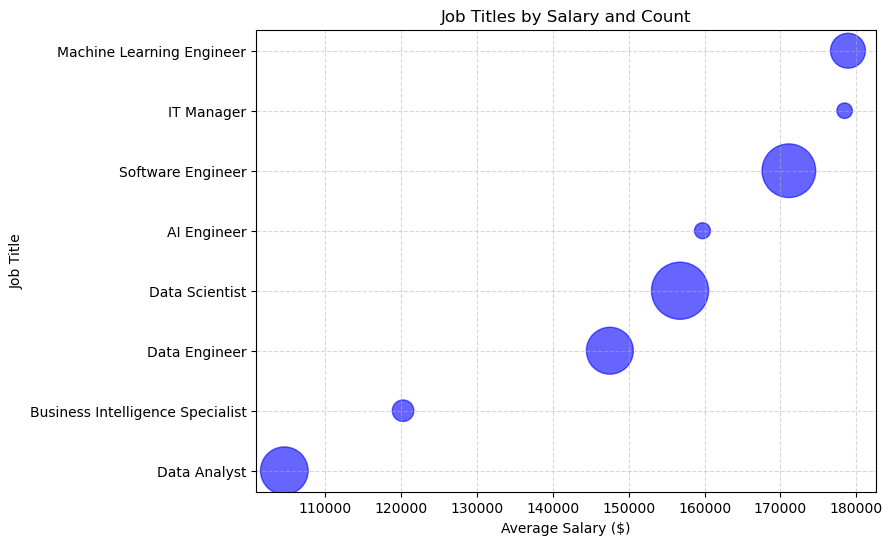

In [56]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    job_title_stats["avg_salary_job_title"], job_title_stats.index, 
    s=job_title_stats["count_job_title"] / 8,  # Scale bubble size
    alpha=0.6, color="blue"
)

plt.xlabel("Average Salary ($)")
plt.ylabel("Job Title")
plt.title("Job Titles by Salary and Count")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

The graph above shows salary difference for each job titles, with the size of bubbles reperesnt the count of job titles. 

We can see from the graph that machine learning field has the highest salary than others like data and AI.

In [57]:
# encode job titles
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
job_title_hot = cat_encoder.fit_transform(df5[['category']])
job_title_hot.toarray()


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [58]:
cat_encoder.categories_

[array(['AI Engineer', 'Business Intelligence Specialist', 'Data Analyst',
        'Data Engineer', 'Data Scientist', 'IT Manager',
        'Machine Learning Engineer', 'Software Engineer'], dtype=object)]

In [59]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cluster_job_title(df):
    df = df.copy()  # Ensure we don't modify the original DataFrame
    
    job_titles = df["job_title"].tolist()
    categories = [
        'AI Engineer', 'Data Architect/ Data ETL Cloud Engineer/ Data Engineer',
        'Data Scientist', 'Data Analyst/Data Specialist',
        'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer',
        'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect',
        'Tableau/BI Analyst/ Business Intelligence Specialist', 'Software Engineer'
    ]

    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(job_titles + categories)

    job_vectors = vectors[: len(job_titles)]
    category_vectors = vectors[len(job_titles) :]

    similarities = cosine_similarity(job_vectors, category_vectors)

    df["category"] = [categories[i] for i in similarities.argmax(axis=1)]
    df["similarities"] = similarities.max(axis=1) 

    df = df[df["similarities"] > 0.2]

    df["category"] = df["category"].replace({
        'Data Analyst/Data Specialist': 'Data Analyst',
        'Data Architect/ Data ETL Cloud Engineer/ Data Engineer': 'Data Engineer',
        'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer': 'Machine Learning Engineer',
        'Tableau/BI Analyst/ Business Intelligence Specialist': 'Business Intelligence Specialist',
        'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect': 'IT Manager'
    })

    df.drop('job_title', axis=1, inplace=True)
    df.rename(columns={"category": "job_title"}, inplace=True)
    
    return df


In [60]:
clustered_cleaned_dsjobs = cluster_job_title(cleaned_dsjobs)

### Creating Preparation Pipeline
my processing

a. Target column
- remove target outliers

b. num features
 - numeric: standard scaler
 - time year: ordinal encoder

c. Cat features
- mapping w/ custom transformer 

c. job titles column
- cluster job titles
- onehotencode job titles


#### Creating  Custom Transformers

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin

In [64]:
# # custom transformers to remove outliers

# class OutlierTargetRemover(BaseEstimator, TransformerMixin):
#     def __init__(self, target_col, remover_base_col, std_factor=2):
#         self.target = target_col
#         self.base = remover_base_col
#         self.std_factor = std_factor  # Flexibility to adjust the standard deviation threshold

#     def fit(self, X, y=None):
#         return self  # No fitting required

#     def transform(self, X, y=None):
#         X = pd.DataFrame(X)  
#         X_transformed = []

#         for _, sub_df in X.groupby(self.base):
#             mean = sub_df[self.target].mean()
#             std = sub_df[self.target].std()
#             filtered = sub_df[
#                 (sub_df[self.target] >= mean - self.std_factor * std) &
#                 (sub_df[self.target] <= mean + self.std_factor * std)
#             ]
#             X_transformed.append(filtered)

#         return pd.concat(X_transformed).reset_index(drop=True)  

In [65]:
# remover = OutlierTargetRemover(target_col='salary_in_usd', remover_base_col='experience_level')
# ds_jobs_cleaned = remover.fit_transform(ds_jobs)
# ds_jobs_cleaned.sample(3)

In [66]:
# ### custom transformers to encode category columns

# class CatAttrEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self  # No fitting required

#     def transform(self, X, y=None):
#         X = pd.DataFrame(X).copy()
    
#         # Encode ordinal categorical features
#         X['experience_level'] = X['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
#         X['company_size'] = X['company_size'].replace({'S': 1, 'M': 2, 'L': 3})

#         # Trim spaces from employment type
#         X['employment_type'] = X['employment_type'].str.strip()

#         # Convert binary categorical features
#         X['fulltime_emp'] = (X['employment_type'] == 'FT').astype(int)
#         X['us_currency'] = (X['salary_currency'] == 'USD').astype(int)
#         X['us_emp_residence'] = (X['employee_residence'] == 'US').astype(int)
#         X['us_company_loc'] = (X['company_location'] == 'US').astype(int)

#         return X[['experience_level', 'company_size', 'fulltime_emp', 'us_currency', 'us_emp_residence', 'us_company_loc']]
    
    
#     ########### add case when remote ratio added

In [67]:
from pipeline import CatAttrEncoder

cat_encoder = CatAttrEncoder()
ds_jobs_encoded = cat_encoder.fit_transform(cleaned_dsjobs)
ds_jobs_encoded.sample(3)

,experience_level,company_size,fulltime_emp,us_currency,us_emp_residence,us_company_loc
4189,2,2,1,1,1,1
2722,1,2,1,0,0,0
67542,3,2,1,1,1,1


In [68]:
# ### custom transformers to cluster job titles

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

# class JobTitleCluster(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self  # No fitting required

#     def transform(self, X, y=None):
#         X = pd.DataFrame(X).copy()
        
#         job_titles = X["job_title"].tolist()
#         categories = ['AI Engineer', 'Data Architect/ Data ETL Cloud Engineer/ Data Engineer',
#                'Data Scientist', 'Data Analyst/Data Specialist', 'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer',
#                'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect', 'Tableau/BI Analyst/ Business Intelligence Specialist', 'Software Engineer']

#         vectorizer = TfidfVectorizer()
#         vectors = vectorizer.fit_transform(job_titles + categories)

#         job_vectors = vectors[: len(job_titles)]
#         category_vectors = vectors[len(job_titles) :]

#         similarities = cosine_similarity(job_vectors, category_vectors)
        
        
#         X["category"] = [categories[i] for i in similarities.argmax(axis=1)]
#         X["similarities"] = similarities.max(axis=1) 
        
#         X = X[X.similarities > 0.2]

#         X.category = X.category.replace({
#             'Data Analyst/Data Specialist': 'Data Analyst',
#             'Data Architect/ Data ETL Cloud Engineer/ Data Engineer': 'Data Engineer',
#             'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer': 'Machine Learning Engineer',
#             'Tableau/BI Analyst/ Business Intelligence Specialist': 'Business Intelligence Specialist',
#             'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect': 'IT Manager'
#         })
#         X.drop('job_title', axis=1, inplace=True)
#         X.rename(columns={"category": "job_title"}, inplace=True)
        
#         return X

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [70]:
# # automate cleaning

# data_preprocessing_pipeline  = Pipeline([
#     ("outlier_removal", OutlierTargetRemover(target_col='salary_in_usd', remover_base_col='experience_level')),
#     ("job_clustering", JobTitleCluster())
# ])

# jobs_cleaned = data_preprocessing_pipeline.fit_transform(ds_jobs)
# jobs_cleaned

In [71]:
# separate X and y values before applying transformation

jobs = clustered_cleaned_dsjobs.drop(['salary', 'salary_in_usd'], axis=1)
jobs_labels = clustered_cleaned_dsjobs.salary_in_usd.copy()

In [72]:
from pipeline import CatAttrEncoder
from pipeline import time_num_pipeline

time_num_attribs = ['work_year']
cat_attribs = ['experience_level', 'employment_type', 'salary_currency',
               'employee_residence', 'company_location', 'company_size']
job_title_attribs = ['job_title']

# create column transformer pipeline to transform attribute values
feature_transformation_pipeline = ColumnTransformer([
    ("time_num", time_num_pipeline, time_num_attribs), # transform year col
    ("cat", CatAttrEncoder(), cat_attribs),
    ("job_title", OneHotEncoder(), job_title_attribs)
])



In [73]:
# # full pipeline

# full_pipeline  = Pipeline([
#     ("job_clustering", JobTitleCluster()),
#     ("feature_transformation", feature_transformation_pipeline)
# ])

jobs_prepared = feature_transformation_pipeline.fit_transform(jobs)
jobs_prepared

array([[-0.07544799,  1.        ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07544799,  1.        ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07544799,  1.        ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.60582416,  3.        ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07544799,  3.        ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.45492818,  3.        ,  2.        , ...,  0.        ,
         1.        ,  0.        ]])

In [74]:
jobs_prepared.shape

(53022, 15)

## Modelling

In [75]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(jobs_prepared, jobs_labels)

LinearRegression()

In [76]:
from sklearn.metrics import mean_squared_error

salary_predictions = lin_reg.predict(jobs_prepared)
lin_mse = mean_squared_error(jobs_labels, salary_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

50643.82027479596

In [77]:
some_data = ds_jobs.iloc[:5]

cleaned_data = cluster_job_title(some_data)

some_data_X = some_data.drop('salary_in_usd', axis=1)
some_data_y = some_data.salary_in_usd.copy()

some_data_prepared = feature_transformation_pipeline.transform(some_data_X)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_data_y))

Predictions: [170672.3490679   40410.3997981  176447.61880544  67232.05659004
 134325.70417129]
Labels: [286000, 44356, 185000, 57066, 172000]


In [78]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(jobs_prepared, jobs_labels)

salary_predictions = tree_reg.predict(jobs_prepared)
tree_mse = mean_squared_error(jobs_labels, salary_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

49693.883130812

In [79]:
print("Predictions:", tree_reg.predict(some_data_prepared))
print("Labels:", list(some_data_y))

Predictions: [173547.79864599  64287.39393939 182588.01240695  67178.55
 126193.89572864]
Labels: [286000, 44356, 185000, 57066, 172000]


In [80]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(jobs_prepared, jobs_labels)

salary_predictions = forest_reg.predict(jobs_prepared)
forest_mse = mean_squared_error(jobs_labels, salary_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

49712.63615377965

###  Better Evaluation Using Cross-Validation

In [81]:
from sklearn.model_selection import cross_val_score

In [82]:
## decision tree
scores = cross_val_score(tree_reg, jobs_prepared, jobs_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [83]:
def display_scores(scores):
    print("Scores:", scores)   
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [84]:
display_scores(tree_rmse_scores)

Scores: [38733.39757267 52834.66747155 48865.42248953 48457.66378028
 52605.22138155 52151.24939111 51872.42149009 53481.78824382
 53063.29525276 52513.43721893]
Mean: 50457.85642923006
Standard deviation: 4234.222720097795


In [85]:
## linear regression
lin_scores = cross_val_score(lin_reg, jobs_prepared, jobs_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [86]:
display_scores(lin_rmse_scores)

Scores: [42925.53101673 51024.19994189 49033.2985186  48813.13600484
 52863.20615532 52416.702641   52046.96660262 53615.10368963
 53269.9649377  52720.05804883]
Mean: 50872.81675571652
Standard deviation: 3085.627950799081


In [87]:
## random forest
forest_scores = cross_val_score(forest_reg, jobs_prepared, jobs_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [88]:
display_scores(forest_rmse_scores)

Scores: [37627.12050821 52692.77464202 48768.02947683 48418.24964266
 52587.45357264 52111.15561355 51863.70762565 53412.37147426
 52963.24308528 52492.29198258]
Mean: 50293.63976236717
Standard deviation: 4525.0252239069205


The best score achieved with Random Forest

## Fine-Tune Model

### Use GridSearch CV

In [89]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
 {'n_estimators': [10, 50, 100], 'max_features': [2, 4, 6, 8, 10]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(jobs_prepared, jobs_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [10, 50, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [90]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 100}

In [91]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50930.1880187841 {'max_features': 2, 'n_estimators': 10}
50912.13988359066 {'max_features': 2, 'n_estimators': 50}
50904.47799020937 {'max_features': 2, 'n_estimators': 100}
50928.81136058693 {'max_features': 4, 'n_estimators': 10}
50916.60125714492 {'max_features': 4, 'n_estimators': 50}
50909.25561475573 {'max_features': 4, 'n_estimators': 100}
50946.22473254665 {'max_features': 6, 'n_estimators': 10}
50919.63879860128 {'max_features': 6, 'n_estimators': 50}
50915.231455243586 {'max_features': 6, 'n_estimators': 100}
50974.59717973199 {'max_features': 8, 'n_estimators': 10}
50917.98200201083 {'max_features': 8, 'n_estimators': 50}
50924.204051979876 {'max_features': 8, 'n_estimators': 100}
50946.85772598347 {'max_features': 10, 'n_estimators': 10}
50930.99196598554 {'max_features': 10, 'n_estimators': 50}
50921.80763583264 {'max_features': 10, 'n_estimators': 100}
50984.149551590766 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
50958.35133911028 {'bootstrap': False, 'max

In [92]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2)

In [93]:
print(np.sqrt(-grid_search.best_score_))

50904.47799020937


### Use RandomizedSearchCV

In [94]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define hyperparameter search space
param_dist = {
    'n_estimators': [40, 50, 60],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [8, 10, 12, 15, None],
    'min_samples_split': [3, 4, 5, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False]
}

# Initialize the model
forest_reg = RandomForestRegressor()

# Randomized search
random_search = RandomizedSearchCV(
    forest_reg, param_distributions=param_dist, 
    n_iter=20,  # Number of random combinations to try
    scoring='neg_mean_squared_error', 
    cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Fit the model
random_search.fit(jobs_prepared, jobs_labels)

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", np.sqrt(-random_search.best_score_))  # Convert to RMSE


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Best Score: 50867.54743778836


Tuning Model doesn't improve base model performance

## Analyze Best Models

In [95]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.02400287, 0.30193842, 0.01260786, 0.0111054 , 0.11061042,
       0.07073344, 0.07028138, 0.00432922, 0.0227608 , 0.23197998,
       0.0194374 , 0.01814223, 0.00764133, 0.04746107, 0.04696819])

In [96]:
time_num_attribs = ["work_year"]
cat_attribs = ['experience_level', 'company_size', 'fulltime_emp', 'us_currency', 'us_emp_residence', 'us_company_loc']
job_title_encoder = feature_transformation_pipeline.named_transformers_["job_title"]
job_title_onehotencode_attribs = list(job_title_encoder.categories_[0])

attributes = time_num_attribs + cat_attribs + job_title_onehotencode_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3019384168390372, 'experience_level'),
 (0.2319799835700699, 'Data Analyst'),
 (0.1106104160273527, 'us_currency'),
 (0.07073343506925496, 'us_emp_residence'),
 (0.07028138139133074, 'us_company_loc'),
 (0.047461066290922796, 'Machine Learning Engineer'),
 (0.046968187564698206, 'Software Engineer'),
 (0.024002866877617324, 'work_year'),
 (0.02276080068152198, 'Business Intelligence Specialist'),
 (0.019437404551983097, 'Data Engineer'),
 (0.01814223373144885, 'Data Scientist'),
 (0.012607858921234805, 'company_size'),
 (0.011105399791244655, 'fulltime_emp'),
 (0.007641333190838773, 'IT Manager'),
 (0.004329215501443974, 'AI Engineer')]

## Evaluate on Test Set

In [97]:
from sklearn.ensemble import RandomForestRegressor


data_cleaned = remove_outlier_salary(ds_jobs)
data_cleaned = cluster_job_title(data_cleaned)

data_X = data_cleaned.drop('salary_in_usd', axis=1)
data_y = data_cleaned.salary_in_usd.copy()

data_prepared = feature_transformation_pipeline.transform(data_X)

forest_reg = RandomForestRegressor()
forest_reg.fit(data_prepared, data_y)


RandomForestRegressor()

In [98]:
final_model = forest_reg

test_set = cluster_job_title(strat_test_set)

X_test = test_set.drop('salary_in_usd', axis=1)
y_test = test_set['salary_in_usd'].copy()

X_test_prepared = feature_transformation_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

62830.6040601068

In [99]:
some_data = ds_jobs.iloc[:5]

some_data_cleaned = cluster_job_title(some_data)

some_data_X = some_data_cleaned.drop('salary_in_usd', axis=1)
some_data_y = some_data_cleaned.salary_in_usd

some_data_prepared = feature_transformation_pipeline.transform(some_data_X)

print("Predictions:", forest_reg.predict(some_data_prepared))
print("Labels:", list(some_data_y))

Predictions: [173490.12747678  64400.14882708 182546.2214482   67341.78195119
 126477.8831988 ]
Labels: [286000, 44356, 185000, 57066, 172000]


## Save Models

In [100]:
import pickle
with open('ds_jobs_salaries_model.pickle', 'wb') as f:
    pickle.dump(forest_reg, f)

In [101]:
import json
columns = {
    'data_columns' : [col for col in ds_jobs.columns if col not in ['salary_in_usd', 'salary']],
    'job_titles': job_title_onehotencode_attribs,
    'company_locations': ds_jobs.company_location.unique().tolist(),
    'currency': ds_jobs.salary_currency.unique().tolist(),
    'employee_residence': ds_jobs.employee_residence.unique().tolist(),
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

In [102]:
import joblib

# Assuming 'pipeline' is your trained model or preprocessing pipeline
joblib.dump(feature_transformation_pipeline, "feature_transformation_pipeline.pkl")

['feature_transformation_pipeline.pkl']